In [1]:
%load_ext autoreload
%autoreload 2

# Simulation settings

In [2]:
from utils.hexec import create_estimator_options
from utils.hexec import ExecDB

L_arr = [8, 16, 24, 32, 40, 48, 50, 52]
# L_arr = [8]
J = 1
h = 0.05
lamb = 0.7
g = None

x_basis = False

particle_pair_left_positions = [L//2 - 1 for L in L_arr]
particle_pair_length = 1

final_time = 8
steps = 35

shots = [50000]

execution_database = "z2_chain_jobs_postselection.json"
job_db = ExecDB(execution_database)

# Device selection

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService
from cobos.tokens import ibm_token, group_instance, group_instance2
# from fradm.tokens import ibm_token, group_instance

channel = "ibm_quantum"
# device = "ibm_kyiv"
# device = "ibm_brisbane"
device = "ibm_fez"
# device = "ibm_sherbrooke"
# device = "ibm_torino"

eplg_absolute = 4.54e-3

service = QiskitRuntimeService(channel=channel, token=ibm_token, instance=group_instance2)
backend = service.backend(device)

# Circuit transpilation, observables & postselection

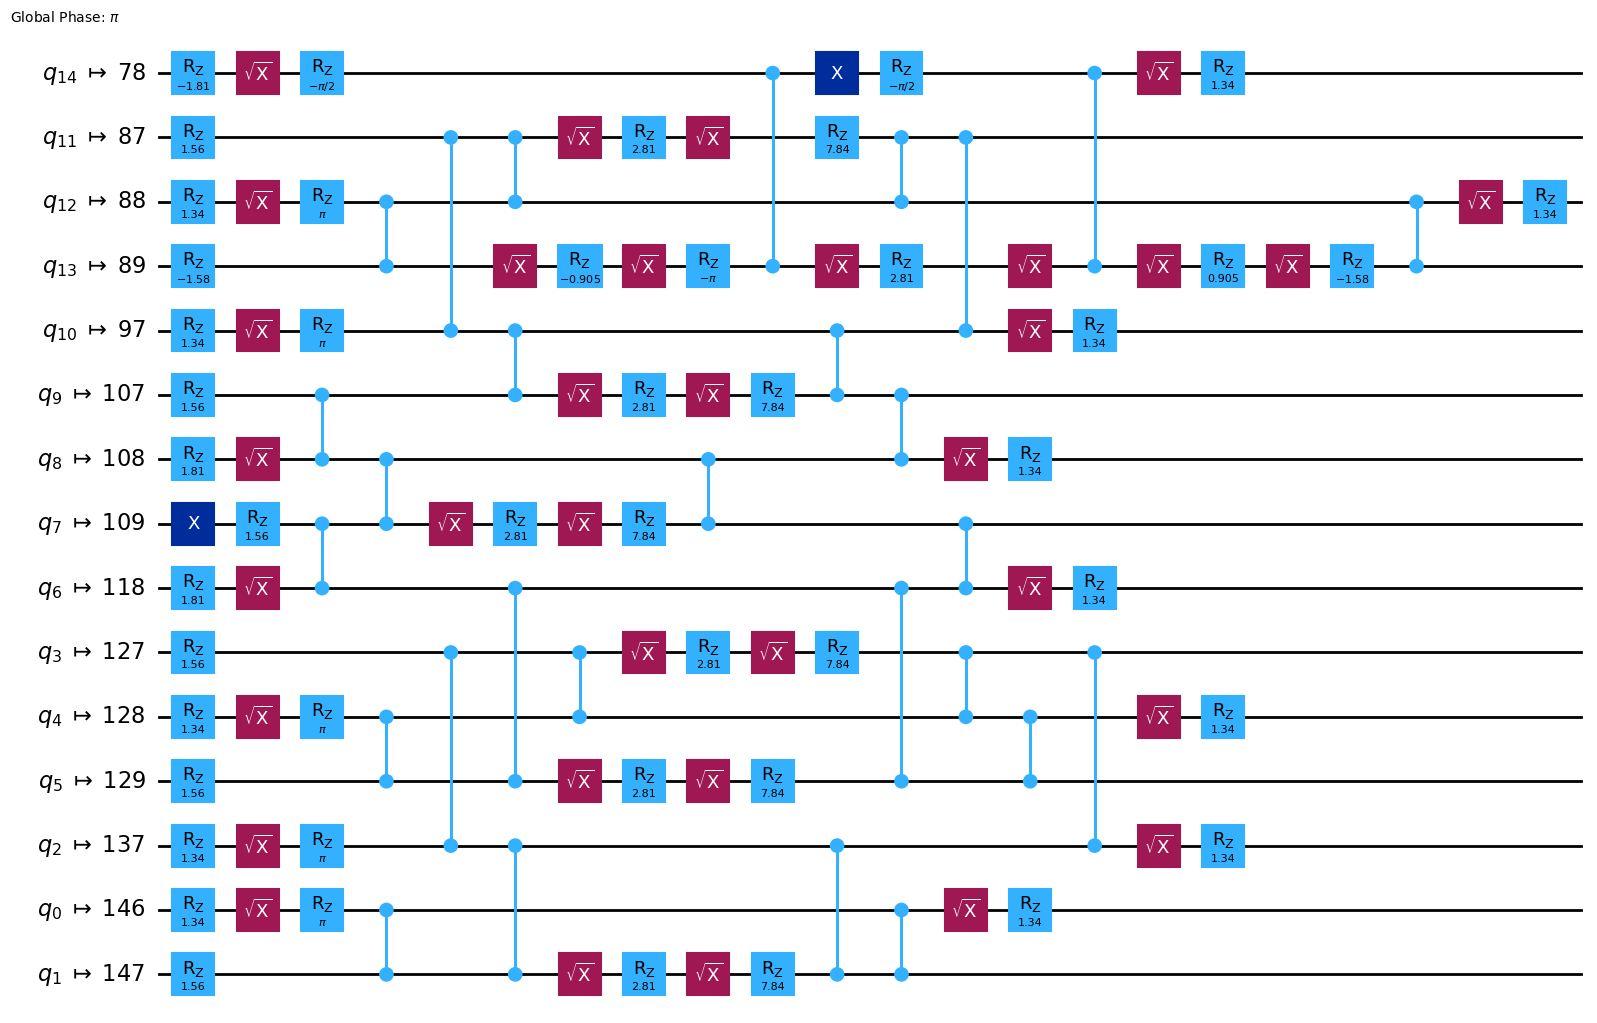

In [4]:
from z2chain.circs import physical_particle_pair_quench_simulation_circuits, erradj_particle_pair_quench_simulation_circuits
from z2chain.operators import local_pauli_z, local_pauli_x, postselection_operators
from utils.hexec import get_backend_best_qubit_chain
from functools import partial

optimization_level = 2

circuits = [] # circuits[L][t]
observable_generating_funcs = [] #observable_generating_funcs[L][i]
postselection_operators_funcs = []

sampler_options = [{
    "default_shots": 10000,
    "execution": {
        "init_qubits": True,
        "meas_type": "classified"
    },
    "dynamical_decoupling": {
        "enable": True,
        "sequence_type": "XY4"
    },
    "twirling": {
        "enable_gates": True,
        "enable_measure": True,
        "num_randomizations": "auto",
        "shots_per_randomization": "auto"
    }
}]
extra_options = [{"backend": device, "L": L, "J": J, "h": h, "λ":lamb, "g": g, "particle_pair_position": pp_pos, "particle_pair_length": particle_pair_length, "final_time": final_time, "eplg": eplg_absolute} for L, pp_pos in zip(L_arr, particle_pair_left_positions)]

for L, pp_ps in zip(L_arr, particle_pair_left_positions):
    qubits_inds = get_backend_best_qubit_chain(backend, 2*L-1)
    physical_circuits = erradj_particle_pair_quench_simulation_circuits(L, J, h, lamb, pp_ps, particle_pair_length, final_time, steps, backend, optimization_level, eplg_absolute, g, qubits_inds, x_basis)
    observable_generating_funcs.append([partial(local_pauli_z if not x_basis else local_pauli_x, qubit_ind=i) for i in range(2*L-1)])
    postselection_operators_funcs.append(lambda nqubits: postselection_operators((nqubits + 1)//2, x_basis))
    circuits.append(physical_circuits)

circuits[0][1].draw(output="mpl", idle_wires=False)

# Post-selected circuit execution

### Send jobs to hardware

In [6]:
from utils.postselection import execute_postselected_sampler_batch

jobs = [] #jobs[L][opts][i]

for i, L in enumerate(L_arr):
    this_L_jobs = []
    for opts_dict in sampler_options:
        this_jobs = execute_postselected_sampler_batch(backend, opts_dict, circuits[i], postselection_operators_funcs[i], observable_generating_funcs[i], extra_options=extra_options[i])
        this_L_jobs.append(this_jobs)
    jobs.append(this_L_jobs)

TypeError: cannot unpack non-iterable bool object

### Load jobs with the same options

In [7]:
from utils.postselection import load_postselected_jobs

jobs = [] #jobs[L][opts][i]
samples_dicts = [] #samples_dicts[L][opts][i]
postselected_samples_dicts = [] #postselected_samples_dicts[L][opts][i]

for i, L in enumerate(L_arr):
    this_L_jobs = []
    this_L_samples_dicts = []
    this_L_postselected_samples_dicts = []
    for opts_dict in sampler_options:
        clean_extra_options = extra_options[i].copy()
        del clean_extra_options["eplg"]
        this_jobs, this_samples_dicts, this_postselected_samples_dicts = load_postselected_jobs(job_db, service, opts_dict, circuits[i], postselection_operators_funcs[i], observable_generating_funcs[i], clean_extra_options, return_samples_dicts=True, return_postselected_samples_dicts=True)
        this_L_jobs.append(this_jobs)
        this_L_samples_dicts.append(this_samples_dicts)
        this_L_postselected_samples_dicts.append(this_postselected_samples_dicts)
    jobs.append(this_L_jobs)
    samples_dicts.append(this_L_samples_dicts)
    postselected_samples_dicts.append(this_L_postselected_samples_dicts)

[<RuntimeJobV2('cvcq90mkmd10008pns30', 'sampler')>,
 <RuntimeJobV2('cvcq91wvawwg008921v0', 'sampler')>,
 <RuntimeJobV2('cvcq92mw5350008wypz0', 'sampler')>,
 <RuntimeJobV2('cvcq93mz17rg008d3deg', 'sampler')>,
 <RuntimeJobV2('cvcq94w8w2g0008e9p0g', 'sampler')>,
 <RuntimeJobV2('cvcq96cz17rg008d3df0', 'sampler')>,
 <RuntimeJobV2('cvcq97m8w2g0008e9p10', 'sampler')>,
 <RuntimeJobV2('cvcq98xw5350008wyq00', 'sampler')>,
 <RuntimeJobV2('cvcq9a5kmd10008pns3g', 'sampler')>,
 <RuntimeJobV2('cvcq9bdz17rg008d3dg0', 'sampler')>,
 <RuntimeJobV2('cvcq9cdw5350008wyq0g', 'sampler')>,
 <RuntimeJobV2('cvcq9dnkmd10008pns4g', 'sampler')>,
 <RuntimeJobV2('cvcq9ex8w2g0008e9p2g', 'sampler')>,
 <RuntimeJobV2('cvcq9fxvawwg008921w0', 'sampler')>,
 <RuntimeJobV2('cvcq9gy8w2g0008e9p30', 'sampler')>,
 <RuntimeJobV2('cvcq9hyw5350008wyq10', 'sampler')>,
 <RuntimeJobV2('cvcq9jyz17rg008d3dh0', 'sampler')>,
 <RuntimeJobV2('cvcq9mekmd10008pns50', 'sampler')>,
 <RuntimeJobV2('cvcq9npz17rg008d3dhg', 'sampler')>,
 <RuntimeJob

# Plots

### Quech plot

In [ ]:
from z2chain.plotting import x_t_plot

for i, L in enumerate(L_arr):
    for j, opts_dict in enumerate(sampler_options):
        print(f"L = {L} / Options = {j}")
        occupations = (1-jobs[i][j])/2
        x_t_plot(occupations, filepath=f"Plots/hardware_postselection_z2pairquench_maxt_{final_time}_steps_{steps}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_pp_{particle_pair_left_positions[i]}_pl_{particle_pair_length}_dc_{sampler_options["dynamical_decoupling"]["sequence_type"]}_xbasis_{x_basis}.png")